In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
TISSUE = 'kidney'
VERSION = 'final'
SAVEFIGS = True

In [22]:
embeddings = pd.read_csv(f'./data/{TISSUE}_{VERSION}_embeddings.csv',index_col=0)

rna = pd.read_csv(f'./data/{TISSUE}_rna.csv',index_col=0)

df = pd.read_csv(f'./data/hpa_v21_{TISSUE}.csv',index_col=0)

df['duplicated'] = df.index.value_counts()[df.index] > 1
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('(Reliability=="Enhanced")')
         .query('~duplicated') )

adata = embeddings.join(df, how='inner')
adata = sc.AnnData(adata[embeddings.columns], obs=adata[df.columns])
adata.var_names = pd.Series(range(adata.shape[1])).astype(str)
adata.obs = adata.obs.join(rna, on='Gene', how='left')
adata.obs['rna_cell_type'] = adata.obs[rna.columns].idxmax(1)
adata.obs['rna_specificity'] = adata.obs[rna.columns].max(1)

adata = adata[~adata.obs['rna_cell_type'].isna()].copy()

adata

AnnData object with n_obs × n_vars = 9736 × 128
    obs: 'Batch', 'Slide', 'Well', 'Tissue', 'Gene name', 'Gene', 'UniProt', 'Antibody', 'nTPM', 'Staining', 'Sex', 'Age', 'Patient', 'URL', 'Level', 'Reliability', 'duplicated', 'epithelial cell of proximal tubule', 'fibroblast', 'glomerular visceral epithelial cell', 'kidney capillary endothelial cell', 'kidney connecting tubule epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell', 'leukocyte', 'mesangial cell', 'parietal epithelial cell', 'renal alpha-intercalated cell', 'renal beta-intercalated cell', 'renal principal cell', 'rna_cell_type', 'rna_specificity'

In [23]:
adata.obs['Gene'].nunique()

1984

In [24]:
# sc.pp.regress_out(adata,'Batch') # interestingly, this doesnt fix it

In [25]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, min_dist=0.5)

Compare dimensionality-reduced structure to transcriptional specificity

... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical


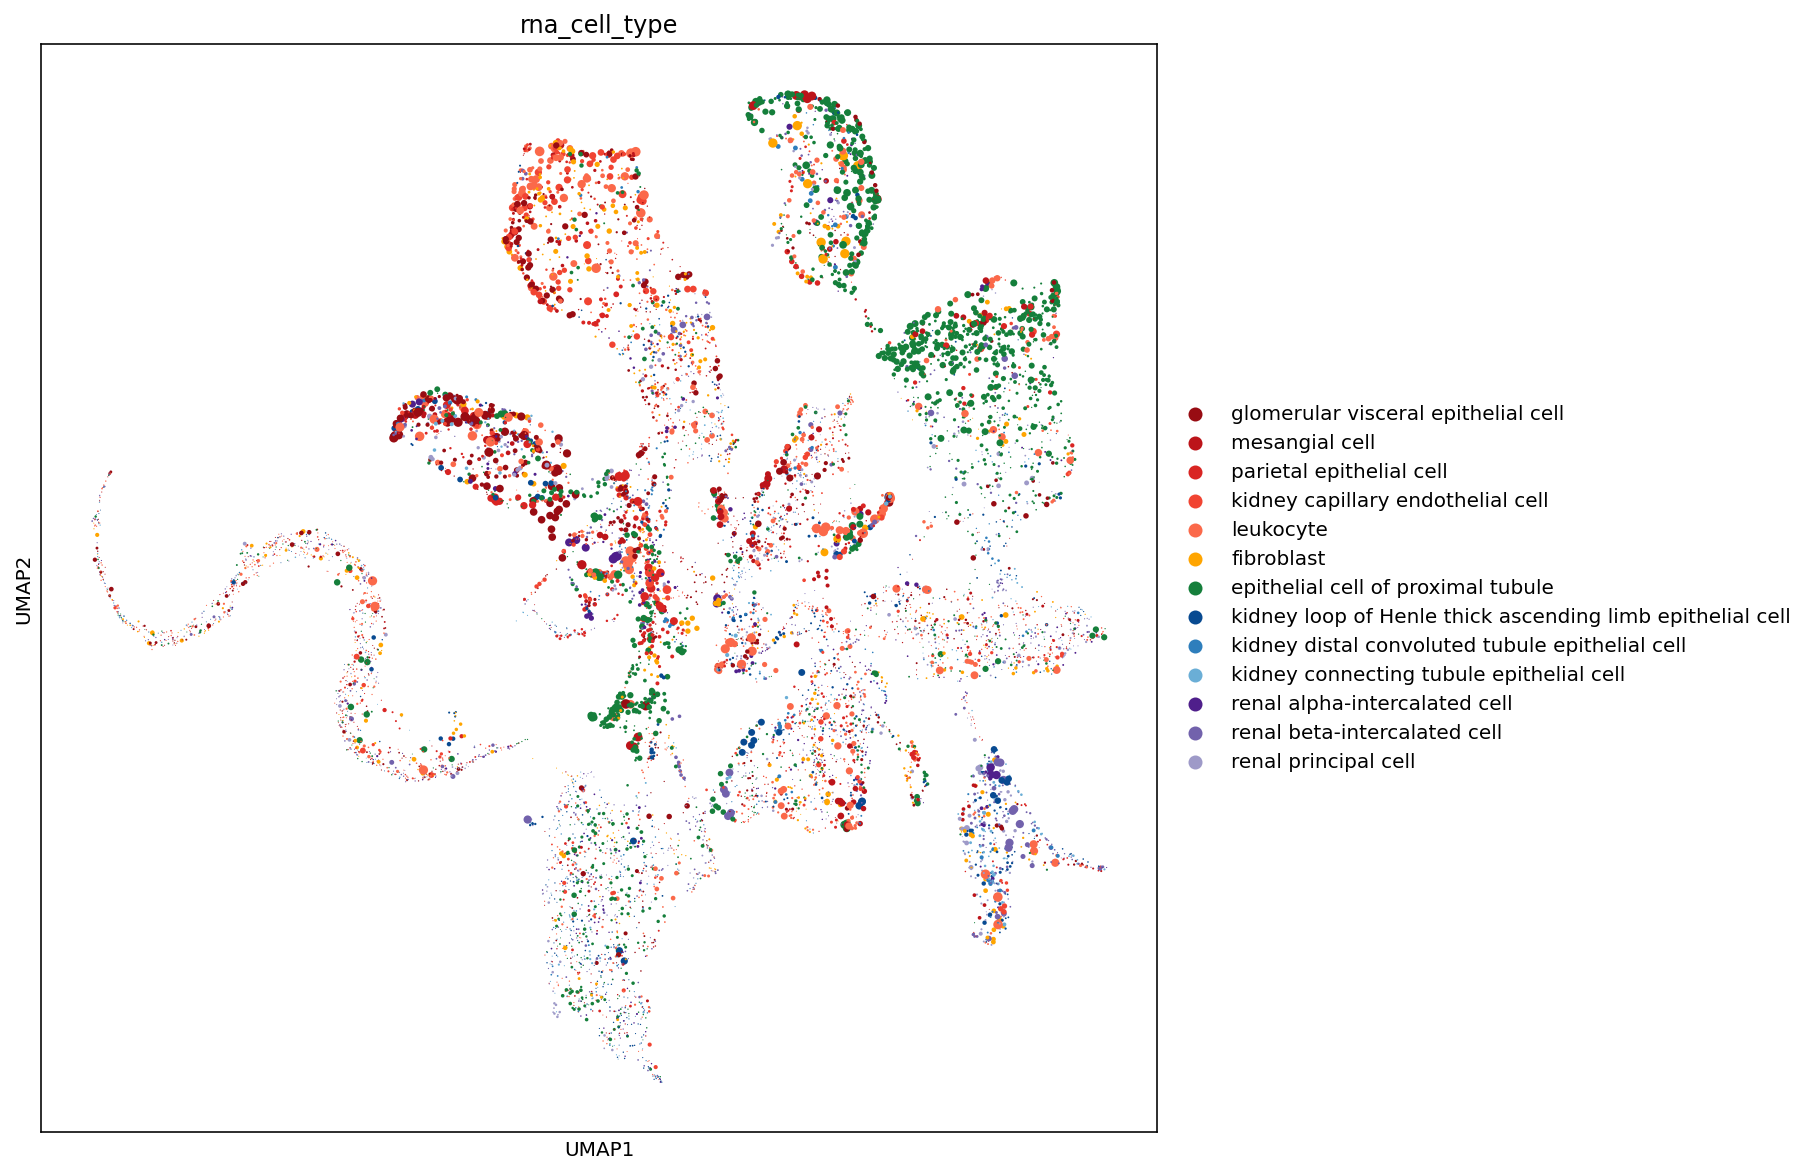

In [26]:
from figures.cell_type_colors import cell_type_colors

adata.obs['rna_cell_type'] = ( adata.obs['rna_cell_type']
                                    .astype('category')
                                    .cat
                                    .reorder_categories(list(cell_type_colors[TISSUE])) )

fig, ax = plt.subplots(figsize=(10,10))
sc.pl.umap(
    adata, 
    color=['rna_cell_type'], 
    palette=cell_type_colors[TISSUE], 
    ax=ax, 
    s=adata.obs['rna_specificity']**2*100,
    na_in_legend=False,
    show=False
)
if SAVEFIGS:
    plt.savefig(f'./figures/{TISSUE}_{VERSION}_umap.png', dpi=300);
else:
    plt.show();

Leiden clusters

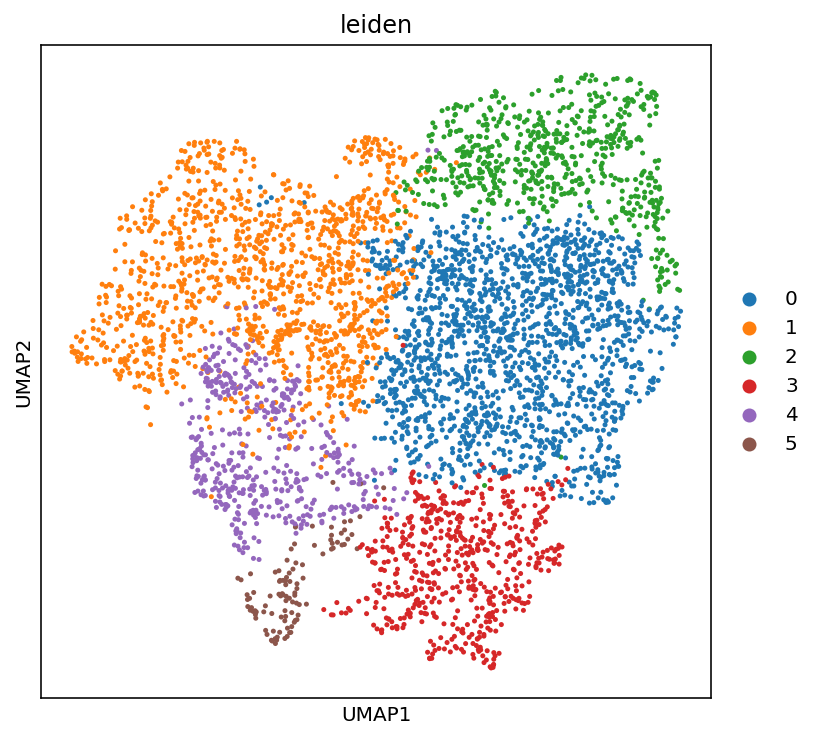

In [8]:
sc.tl.leiden(adata, resolution=0.2)

sc.pl.umap(adata, color='leiden', ax=plt.subplots(figsize=(6,6))[1], show=False)
if SAVEFIGS:
    plt.savefig(f'./figures/{TISSUE}_{VERSION}_leiden.png', dpi=300);
else:
    plt.show();

Assess mixing of covariates

... storing 'Patient' as categorical


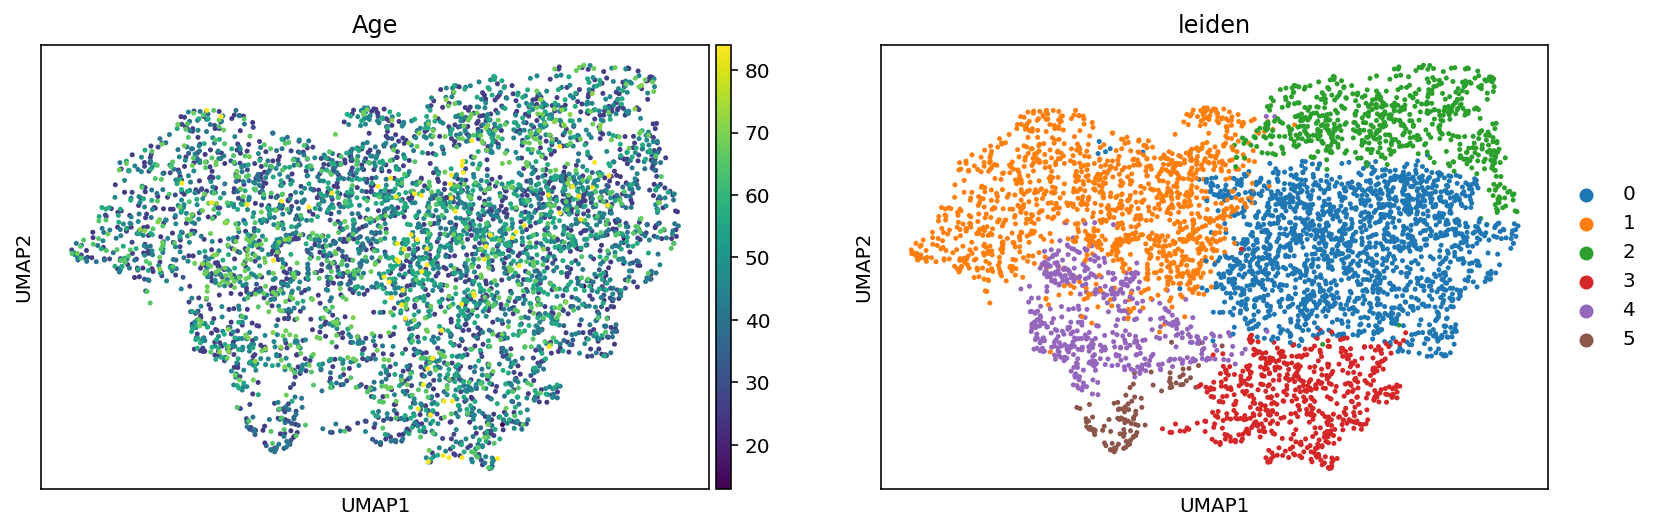

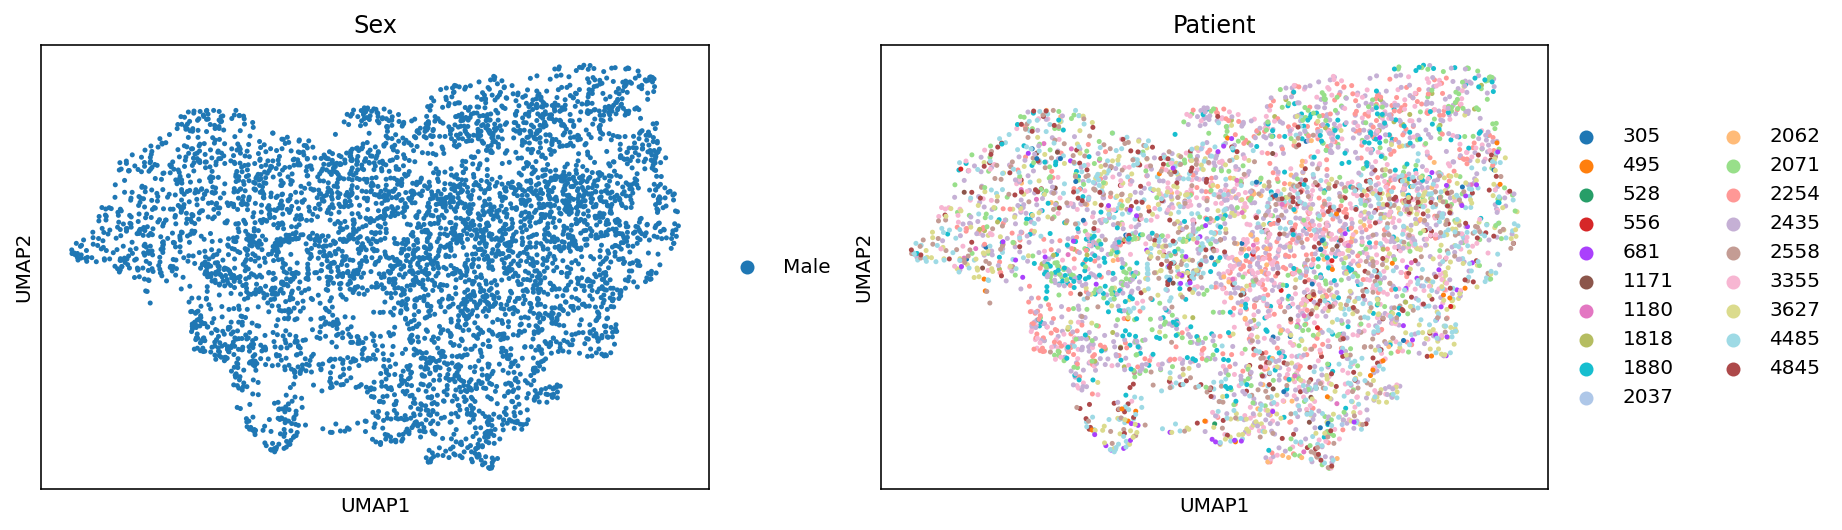

In [9]:
adata.obs['Patient'] = adata.obs['Patient'].astype(str)
sc.pl.umap(adata,color=['Age','leiden'])
sc.pl.umap(adata,color=['Sex','Patient'])

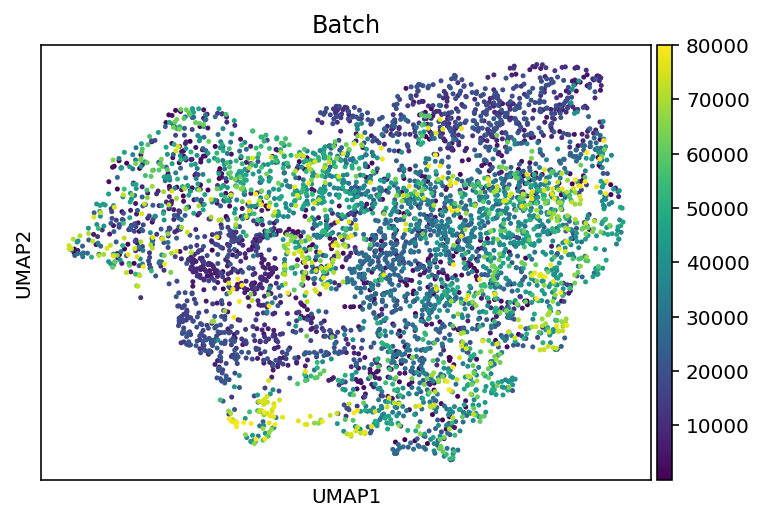

<Figure size 432x288 with 0 Axes>

In [10]:
sc.pl.umap(adata,color=['Batch'])
if SAVEFIGS:
    plt.savefig(f'./figures/{TISSUE}_{VERSION}_batch.png', dpi=300);
else:
    plt.show();

In [11]:
from sklearn.metrics import adjusted_mutual_info_score
ami = adjusted_mutual_info_score(
    adata.obs['leiden'], 
    adata.obs['Patient']
)
ami

0.061319943641453406

Batch confounding

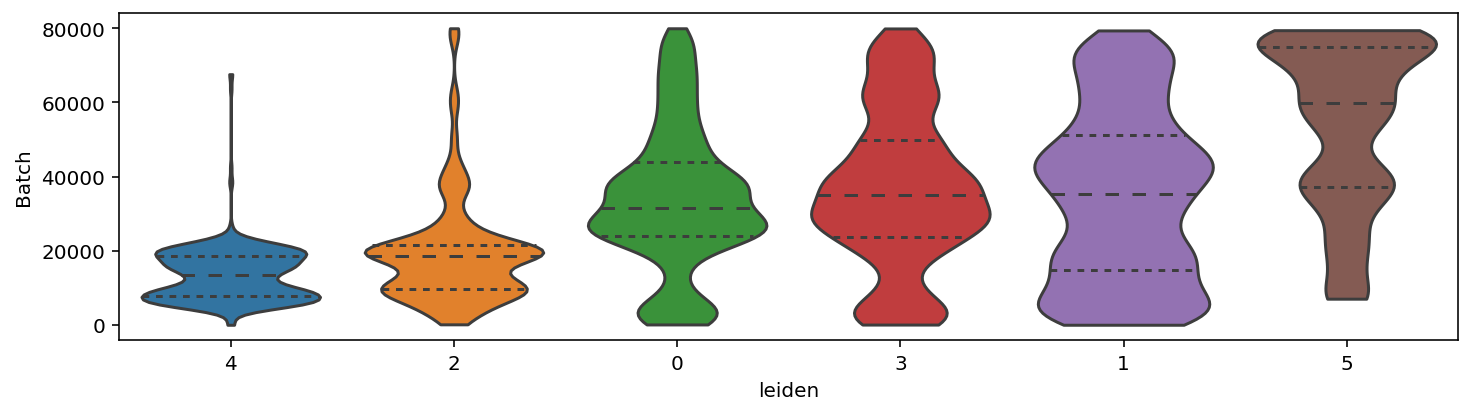

In [12]:
plt.figure(figsize=(12,3))
sns.violinplot(
    data=adata.obs,
    x='leiden',
    y='Batch',
    order=adata.obs.groupby('leiden')['Batch'].median().sort_values().index,
    inner='quartile',
    scale='width',
    cut=0,
    bw=0.2
);

Age confounding

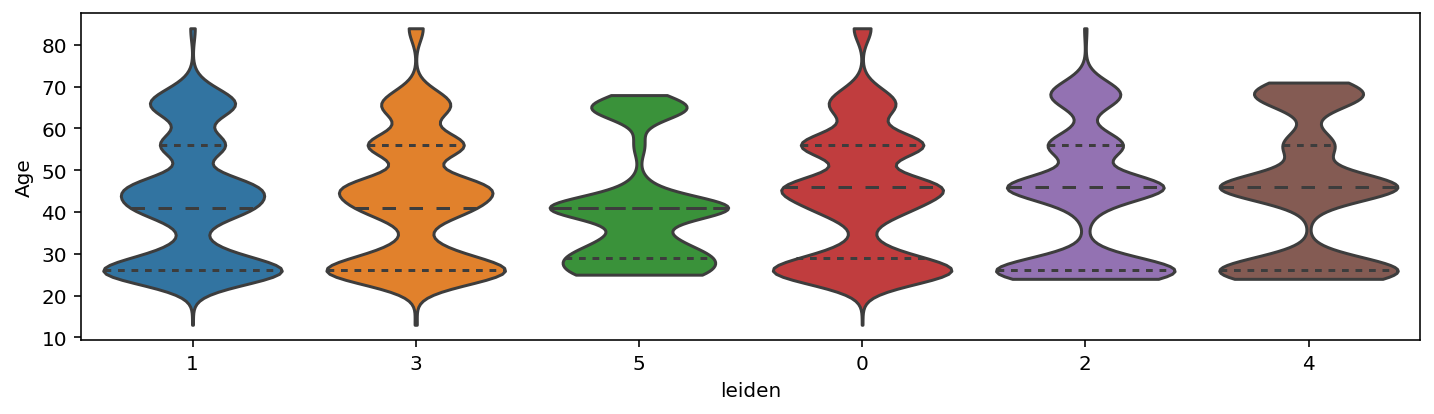

In [13]:
plt.figure(figsize=(12,3))
sns.violinplot(
    data=adata.obs,
    x='leiden',
    y='Age',
    order=adata.obs.groupby('leiden')['Age'].median().sort_values().index,
    inner='quartile',
    scale='width',
    cut=0,
    bw=0.2
);

Sex confounding

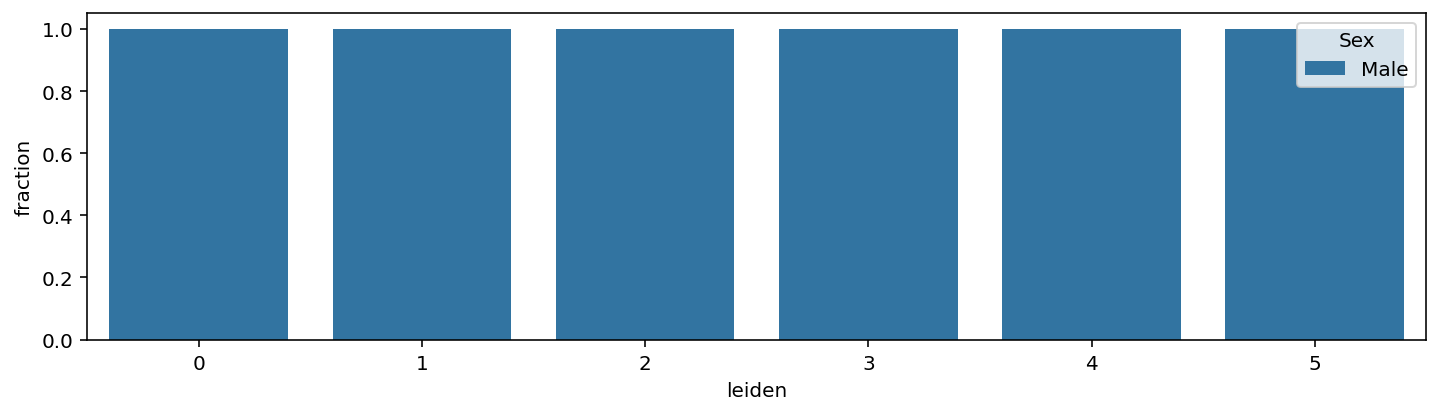

In [14]:
plt.figure(figsize=(12,3))
sns.barplot(
    data=adata.obs.groupby('leiden')['Sex'].value_counts(normalize=True).rename('fraction').reset_index(),
    x='leiden',
    y='fraction',
    hue='Sex'
);

In [15]:
from sklearn.metrics import adjusted_mutual_info_score
ami = adjusted_mutual_info_score(
    adata.obs['leiden'], 
    adata.obs['Sex']
)
ami

1.9089201527133484e-16

In [16]:
# from sklearn.metrics.cluster import contingency_matrix
# from src.stats import hgtest

# adata.obs['Patient'] = adata.obs['Patient'].astype('category')
# # mtx = contingency_matrix(adata.obs['Patient'].cat.codes,adata.obs['leiden'].cat.codes)
# # mtx = pd.DataFrame(mtx,
# #                    index=adata.obs['Patient'].cat.categories,
# #                    columns=adata.obs['leiden'].cat.categories).T

# # mtx = mtx / mtx.values.sum(1,keepdims=True)
# mtx = pd.DataFrame(np.zeros((adata.obs['Patient'].nunique(),)*2),index=adata.obs['Patient'].cat.categories,columns=adata.obs['Patient'].cat.categories)
# # how often do patients (i,j) occur in same cluster?
# for c, df_c in adata.obs.groupby('leiden'):
#     for i in df_c['Patient']:
#         for j in df_c['Patient']:
#             mtx[i][j] += 1

# mtx.values[:] = mtx.values / (np.diag(mtx)[:,None] @ np.diag(mtx)[None,:])
            
# sns.clustermap(mtx, 
#                method='ward',
#                cmap='Reds',
#                annot=mtx,
# #                fmt='.2f',
#                figsize=(12,12),
#                vmax=1e-3,
#               )

Enrichment analysis: RNA cell type

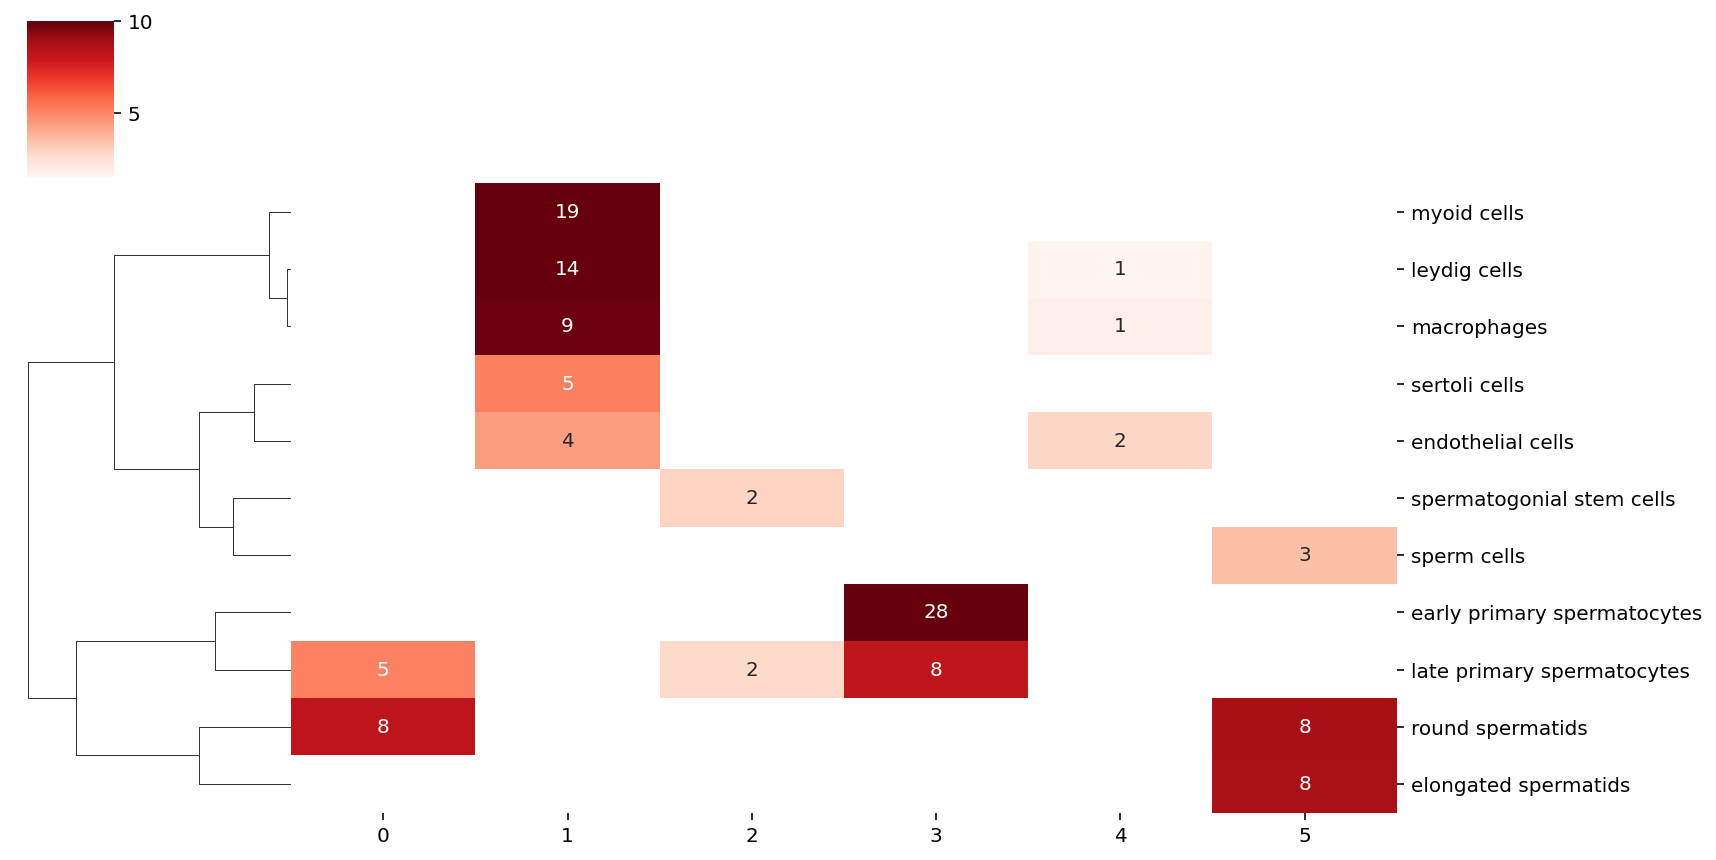

In [17]:
from sklearn.metrics.cluster import contingency_matrix
from src.stats import hgtest

mtx = contingency_matrix(adata.obs['rna_cell_type'].cat.codes,adata.obs['leiden'].cat.codes)
mtx = pd.DataFrame(mtx,
                   index=adata.obs['rna_cell_type'].cat.categories,
                   columns=adata.obs['leiden'].cat.categories).T
pvals = hgtest(mtx)
x = (-np.log10(pvals)).T

sns.clustermap(x.clip(0,10),
               method='ward',
               col_cluster=False,
               cmap='Reds',
               mask=x<-np.log10(0.05),
               annot=np.floor(x),
               fmt='.0f',
               figsize=(12,6)
              );

Enrichment analysis: HPA subcellular localization

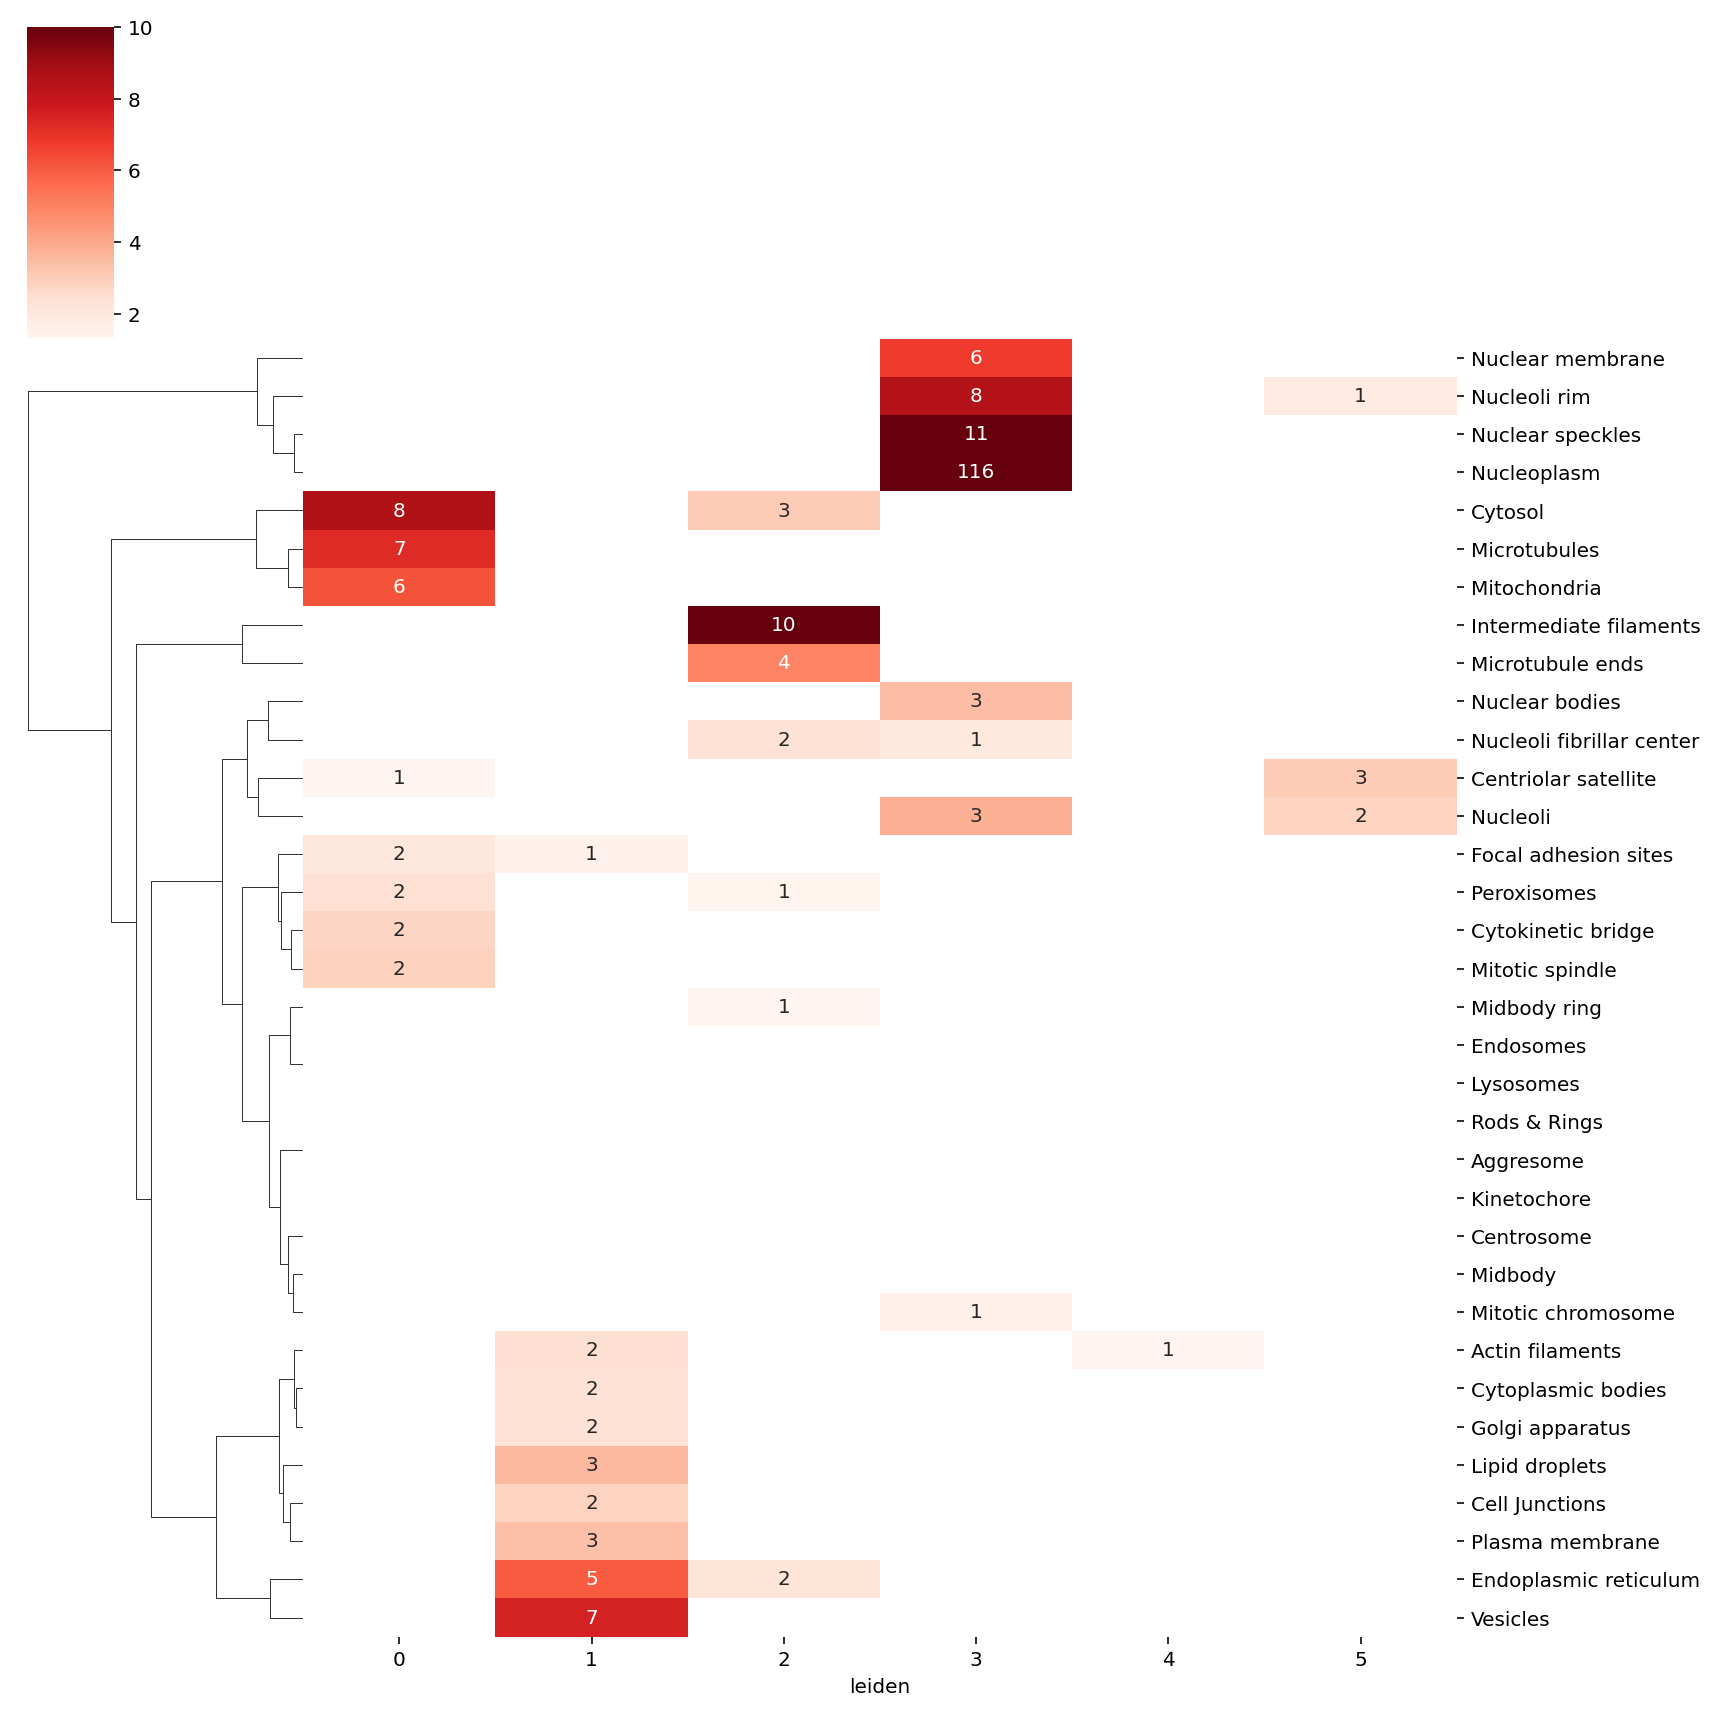

In [18]:
scl = pd.read_table('./data/subcellular_location.tsv')
scl = scl.set_index('Gene')['Main location'].str.split(';',expand=True).melt(ignore_index=False)
scl = scl.groupby('Gene')['value'].value_counts().unstack(fill_value=0)

adata.obs = adata.obs.join(scl,how='left',on='Gene')

pvals = hgtest(adata.obs.groupby('leiden')[scl.columns].sum().dropna().astype(int))
x = (-np.log10(pvals)).T

sns.clustermap(x.clip(0,10),
               method='ward',
               col_cluster=False,
               cmap='Reds',
               mask=x<-np.log10(0.05),
               annot=np.floor(x),
               fmt='.0f',
               figsize=(12,12)
              );

In [19]:
!mkdir -p ./scratch
adata.write(f'./scratch/{TISSUE}_{VERSION}.h5')

... storing 'Gene' as categorical
